## Imports

In [1]:
# Numbers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Graphs
import seaborn as sns

# ML
import sklearn
import sklearn.model_selection
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Pipeline
from sklearn.model_selection import train_test_split # For train/test splits
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline

# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV # For optimization

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.metrics import balanced_accuracy_score

## Loading Data

In [3]:
data_train = pd.read_csv("heart_train.csv")
data_train_oh = pd.get_dummies(data_train, drop_first=True).iloc[:,2:]

data_test = pd.read_csv("heart_test.csv")
data_test_oh = pd.get_dummies(data_test, drop_first=True).iloc[:,2:]

<Axes: >

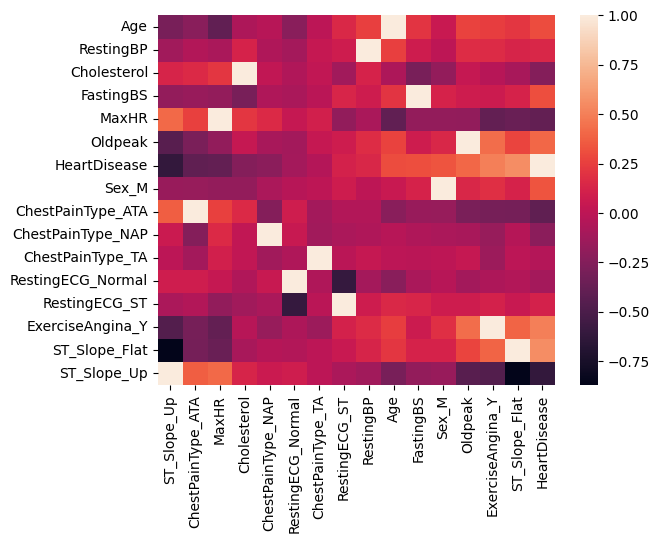

In [4]:
train_cor = data_train_oh.corr().sort_values("HeartDisease",axis = 1)
sns.heatmap(train_cor)

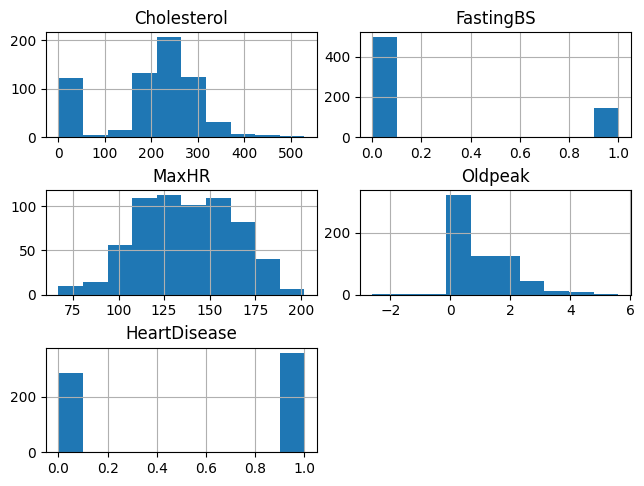

In [5]:
data_train_oh.iloc[:,2:].hist()
plt.tight_layout( pad = 0.5)

Separating X values for data_train

In [6]:
data_trainX = data_train_oh.loc[:,data_train_oh.columns != 'HeartDisease']
data_trainX

data_testX = data_test_oh.loc[:,data_test_oh.columns != 'HeartDisease']
data_testX

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,69,122,216,1,84,0.0,True,False,False,False,False,False,True,True,False
1,74,145,216,1,116,1.8,True,False,False,True,True,False,True,True,False
2,66,146,278,0,152,0.0,False,False,True,False,False,False,False,True,False
3,53,144,300,1,128,1.5,True,False,False,False,False,True,True,True,False
4,41,105,198,0,168,0.0,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,60,150,258,0,157,2.6,False,False,False,False,False,False,False,True,False
271,58,132,224,0,173,3.2,True,False,True,False,False,False,False,False,True
272,62,139,170,0,120,3.0,True,False,False,False,False,True,True,True,False
273,55,135,204,1,126,1.1,True,False,False,False,False,True,True,True,False


Separating Y values for data_test

In [7]:
data_trainY = data_train["HeartDisease"]
data_trainY

0      0
1      1
2      0
3      1
4      0
      ..
638    1
639    1
640    1
641    1
642    0
Name: HeartDisease, Length: 643, dtype: int64

## Normalizing Data (Need to standarize data first)

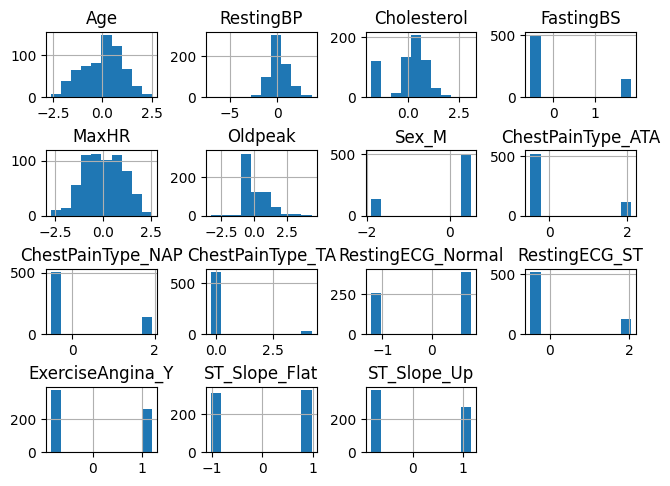

In [8]:
scaler = sklearn.preprocessing.StandardScaler().set_output(transform="pandas")

data_trainX_scl = scaler.fit_transform(data_trainX)
data_trainX_scl.hist()
plt.tight_layout(pad = 0.5)

Feature Select

In [9]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))\
.set_output(transform="pandas")

X_new = model.fit_transform(data_trainX_scl, data_trainY)
set(X_new.columns.tolist())

{'Age',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'Cholesterol',
 'ExerciseAngina_Y',
 'FastingBS',
 'Oldpeak',
 'ST_Slope_Flat',
 'ST_Slope_Up',
 'Sex_M'}

In [10]:
set(data_trainX_scl.columns.tolist()) - set(X_new.columns.tolist())

{'ChestPainType_TA',
 'MaxHR',
 'RestingBP',
 'RestingECG_Normal',
 'RestingECG_ST'}

# Pipeline

## Splitting the test data into training, validation and test
[Source](https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn)

In [11]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X_new, data_trainY, test_size=0.25)

## Model

In [12]:
data_trainY.value_counts()

HeartDisease
1    359
0    284
Name: count, dtype: int64

### Random forest

In [13]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

RandomForestClassifier()

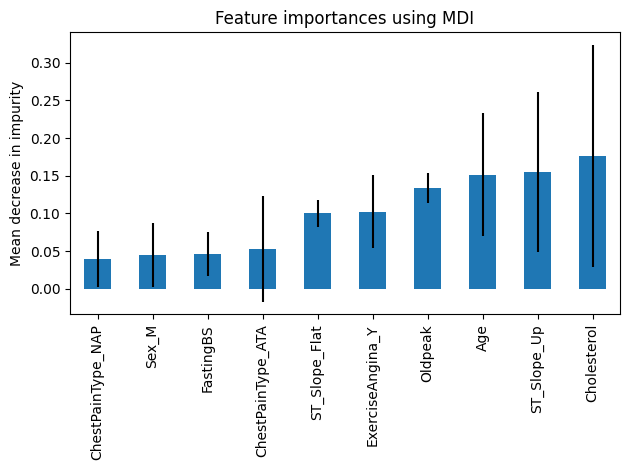

In [14]:


importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

# Plotting
feature_names = x_train.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values()
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
#ax.xtikcks(feature_names)
fig.tight_layout()

#### Tree Validation

In [15]:
# On test data
y_pred = clf.predict(x_test)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Ballanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))


# On train data
y_pred = clf.predict(x_train)
print("Confusion matrix:")
print(confusion_matrix(y_train, y_pred))
print("Accuracy on training data:", accuracy_score(y_train, y_pred))
print("Ballanced accuracy on train data:", balanced_accuracy_score(y_train, y_pred))


# On val data
#y_pred = clf.predict(x_val)
#print("Confusion matrix:")
#print(confusion_matrix(y_val, y_pred))
#print("Accuracy on val data:", accuracy_score(y_val, y_pred))
#print("Ballanced accuracy on val data:", balanced_accuracy_score(y_val, y_pred))

Confusion matrix:
[[61  7]
 [10 83]]
Accuracy on test data: 0.8944099378881988
Ballanced accuracy on test data: 0.8947659709044908
Confusion matrix:
[[215   1]
 [  0 266]]
Accuracy on training data: 0.9979253112033195
Ballanced accuracy on train data: 0.9976851851851851


### Logistic regression

<Axes: ylabel='Feature'>

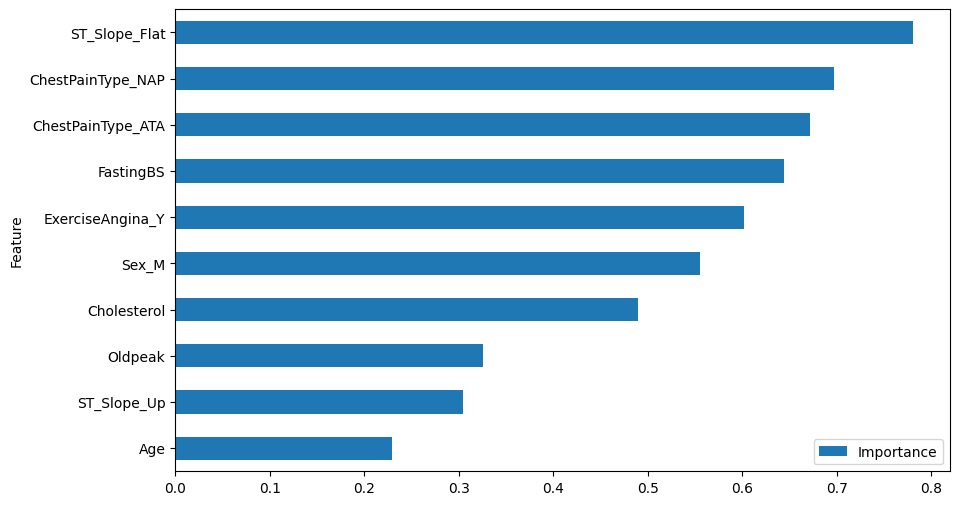

In [17]:
model = LogisticRegression()
model.fit(x_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_new.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
#accuracy_score(y_test, y_pred)

## Data Summary


In [19]:
n_num_col = train.select_dtypes(exclude= "number").columns
n_num_col

## Satistics

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = train_hot["HeartDisease"]
X = train_hot.iloc[:,2:-2].select_dtypes("number").drop(["Oldpeak"], axis = 1)
X_scale = scaler.fit_transform(train_hot)


'\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\n\ny = train_hot["HeartDisease"]\nX = train_hot.iloc[:,2:-2].select_dtypes("number").drop(["Oldpeak"], axis = 1)\nX_scale = scaler.fit_transform(train_hot)\n'

## Training

## Validation

## Creating data for submission

### Loading test data

In [ ]:
data_test = pd.read_csv("/content/heart/heart_test.csv")

### Cleaning test data

### Scaling test data

In [ ]:
scaler = sklearn.preprocessing.StandardScaler().fit(data_test)
data_trainX = scaler.transform(data_test)

### Generating predictions

### Saving predictions to CSV